In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import *
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
import hiddenlayer as hl
from grad_cam2 import *

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet
import matplotlib.cm as cm
from models.original_resnet import resnet18


In [3]:
image_path = 'examples/both.png'

In [88]:
# with open('saved_models/model_image_Aug.15_11.40.44/params.yaml.txt', 'r') as f:
#     params = yaml.load(f)
# params['tb'] = False
# params['log'] = False
# params['save_model'] = False
# d = datetime.now().strftime('%b.%d_%H.%M.%S')
# helper = ImageHelper(current_time=d, params=params, name='image')

In [5]:
helper.test_batch_size = 100

In [6]:
helper.device = 'cpu'

def load_model(path, smooth=False):
    if not smooth:
        dicts = torch.load(f'saved_models/model_image_{path}/model_last.pt.tar')
        model = ResNet18()
       
    else:
        dicts = torch.load(path)
        model = sresnet(depth=110, num_classes=10)
        model = torch.nn.Sequential(NormalizeLayer(), model)
    model.load_state_dict(dicts['state_dict'])     
    model = model.to(helper.device)
    model.eval()
    return model

criterion = torch.nn.CrossEntropyLoss()
helper.load_cifar10(1)
for (batch, target) in helper.test_loader:
    batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)
    break


Files already downloaded and verified
Files already downloaded and verified


AttributeError: 'int' object has no attribute 'clone'

In [7]:
# normally_poisoned 'cifar_Oct.01_11.37.45'
# trained 'cifar_Oct.01_01.18.48'
# 'Aug.15_11.40.44'
# 'cifar_Oct.01_01.18.48'
name = 'cifar_Oct.01_11.37.45'
model = load_model(name)
gcam = GradCAM(model=model)

In [9]:
target

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])

In [135]:
torch.max(model(batch), 1)[1]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 7, 3, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 5, 8, 8, 1, 1, 7, 2, 5, 2, 3, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])

In [8]:

def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device


def get_classtable():
    classes = []
    with open("samples/synset_words.txt") as lines:
        for line in lines:
            line = line.strip().split(" ", 1)[1]
            line = line.split(", ", 1)[0].replace(" ", "_")
            classes.append(line)
    return classes


def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image


def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))


def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))


def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)


# torchvision models
model_names = sorted(
    name
    for name in models.__dict__
    if name.islower() and not name.startswith("__") and callable(models.__dict__[name])
)


In [17]:
batch[1:1].shape

torch.Size([0, 3, 32, 32])

In [11]:
gcam.forward(batch[1:2])

torch.return_types.sort(
values=tensor([[0.1658, 0.1126, 0.1083, 0.1035, 0.1010, 0.1000, 0.0863, 0.0799, 0.0762,
         0.0663]], grad_fn=<SortBackward>),
indices=tensor([[8, 4, 3, 5, 2, 6, 0, 9, 7, 1]]))

In [21]:
target[1:2]

tensor([8])

In [12]:
import os.path as osp
import matplotlib.cm as cm
import cv2

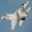

tensor(0)


In [118]:
i=10
im = pilimage(unnorm(batch_poison[i]))
display(im, metadata={'width':200})
print(target[i])

In [16]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [120]:
target_poison, target

(tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8]),
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
         5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
         7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
         8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
         6, 0, 0, 7]))

In [121]:
batch[1].shape

torch.Size([3, 32, 32])

In [344]:
np.moveaxis(cm.jet_r(regions[0,0]),2,0).shape

(4, 32, 32)

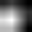

In [429]:
display(pilimage(regions[0,0]), metadata={'width': 200})

In [369]:
cm.jet_r(regions[0,0]).shape

(32, 32, 4)

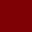

In [112]:
t1 = torch.tensor(( np.moveaxis(cm.jet_r(regions[0,0]),2,0)[:3,...]).astype(np.float32))
display(pilimage(t1), metadata={'width': 200})

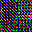

In [75]:
t1 = torch.tensor((cm.jet_r(regions[0,0])[..., :3] * 255.0).astype(np.float32)).view(3,32,32)
display(pilimage(t1), metadata={'width': 200})

In [484]:
regions.shape

torch.Size([1, 1, 32, 32])

In [483]:
c = abs(1-(np.moveaxis(cm.jet_r(regions[0,0]),2,0)))

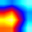

In [481]:
display(pilimage(torch.tensor(( c[:3,...]).astype(np.float32))), metadata={'width': 400})


In [14]:
classes = ['plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<IPython.core.display.Javascript object>


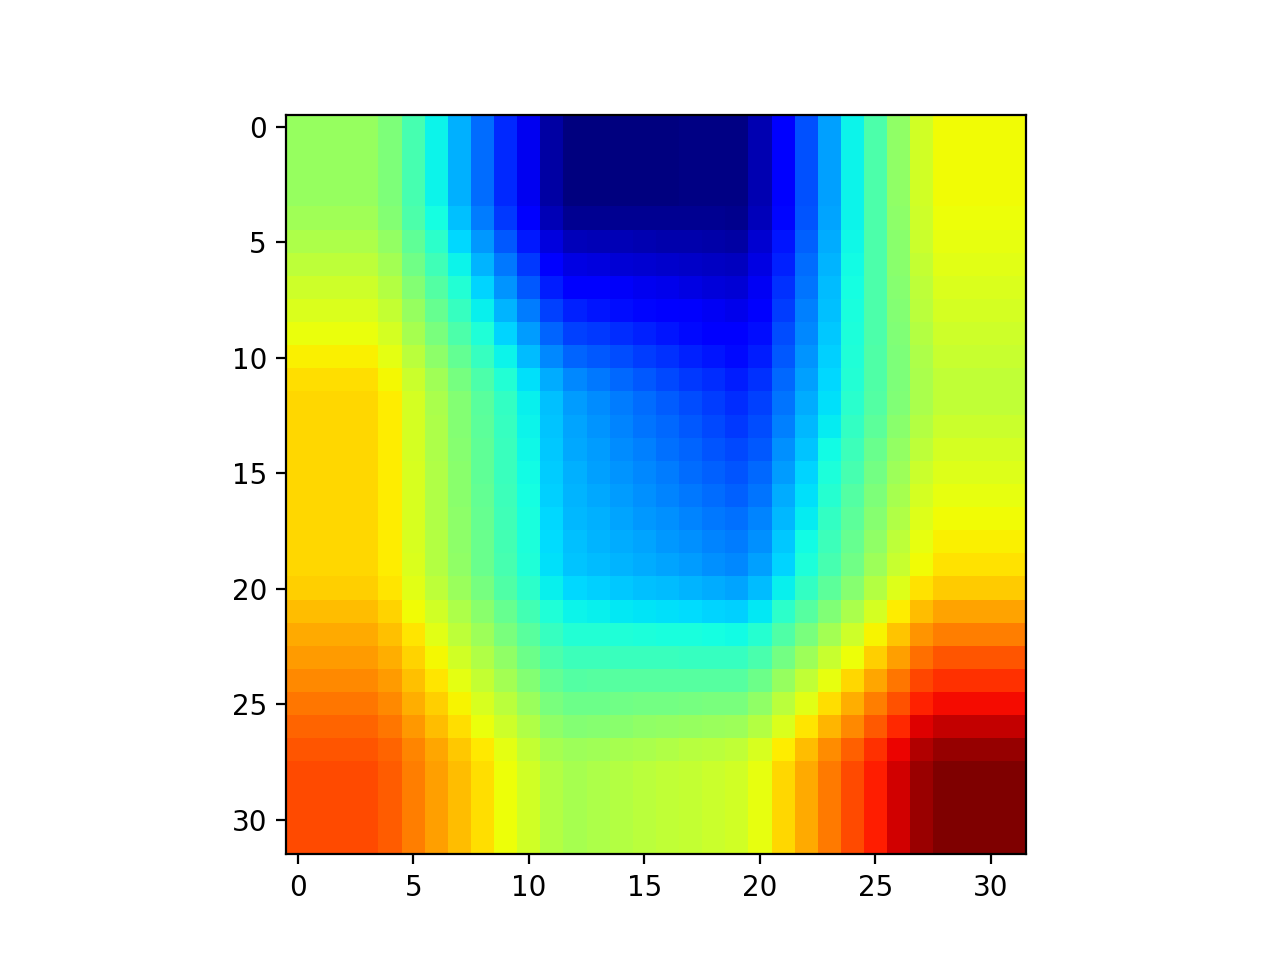

In [367]:
%matplotlib notebook
plt.imshow(pilimage(mask))

In [368]:
regions

tensor([[[[0.1437, 0.1437, 0.1437,  ..., 0.0045, 0.0045, 0.0045],
          [0.1437, 0.1437, 0.1437,  ..., 0.0045, 0.0045, 0.0045],
          [0.1437, 0.1437, 0.1437,  ..., 0.0045, 0.0045, 0.0045],
          ...,
          [0.7220, 0.7220, 0.7220,  ..., 0.0000, 0.0000, 0.0000],
          [0.7220, 0.7220, 0.7220,  ..., 0.0000, 0.0000, 0.0000],
          [0.7220, 0.7220, 0.7220,  ..., 0.0000, 0.0000, 0.0000]]]])

In [275]:
i=19
model.forward( batch[i:i+1].clone()).max(dim=1), target[i]

(torch.return_types.max(
 values=tensor([8.9062], grad_fn=<MaxBackward0>),
 indices=tensor([6])), tensor(6))

In [279]:
gcam.forward( batch[i:i+1].clone())[1][0][0].item()

6

In [166]:
def plot_it(i, poison=False, tp=False):
    %matplotlib notebook

    correct_class = target[i].item()
    if poison:
        images = batch_poison[i:i+1].clone()
        target_class = target_poison[i].item()
    else:
        images = batch[i:i+1].clone()
        target_class = target[i].item()
        if tp:
            target_class = target_poison[i].item()
        
    probs, ids = gcam.forward(images)
    
    print(f'correct label {classes[correct_class]}. Checking: {classes[target_class]}, Poison: {poison},' + 
          f' Predicted: {classes[ids[0][0].item()]}')
    target_layers = ["layer4"]
    
    device = 'cpu'
    output_dir = 'output'

    fig, ax = plt.subplots(1,2)


    
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)
    im1 = pilimage(unnorm(images[0]))
    ax[0].imshow(im1)
    ax[0].title.set_text('original: ')
    # display(im1, metadata={'width':200})

    for pos, target_layer in enumerate(target_layers):
#         print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        image = images[0]
#         mask = torch.tensor(( np.moveaxis(cm.jet_r(regions[0,0]),2,0)[:3,...]).astype(np.float32))
        mask = regions[0,0]*(regions[0,0]>0.5)
#         im2 =  pilimage((unnorm(image) + mask)/2)
        im2 =  pilimage(unnorm(image) * mask )
    #     im2 = pilimage(unnorm(regions[0]))
    #     display(im2, metadata={'width':200})

#         x = (pos+1)//2
#         y = (pos + 1) - x*2
#         ax[x].imshow(im2)
#         ax[x].title.set_text(target_layer)
#         ax[1].imshow(im2)
        ax[1].imshow(cv2.applyColorMap(np.uint8(255 *regions[0,0].numpy()), cv2.COLORMAP_JET)[:,:,::-1])
        ax[1].title.set_text(target_layer)


    plt.tight_layout()    
    return regions[0,0]

In [22]:
batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)

# Simply backdoored

correct label ship. Checking: ship, Poison: False, Predicted: ship


<IPython.core.display.Javascript object>


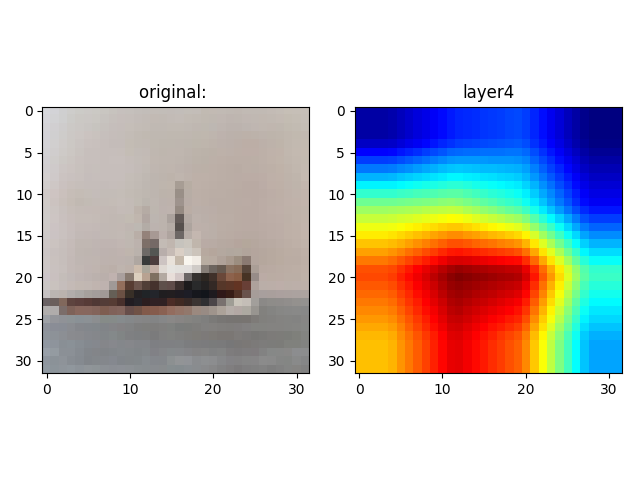

In [170]:
name = 'cifar_Oct.01_11.37.45'
model = load_model(name)
gcam = GradCAM(model=model)
a = plot_it(i=72, poison=False, tp=False)

In [137]:
a.shape

torch.Size([32, 32])

In [143]:
np.uint8(255 *a.numpy())[-1]

array([ 43,  43,  43,  43,  48,  56,  65,  74,  83,  92, 101, 110, 113,
       111, 110, 108, 106, 104, 102, 101,  93,  81,  68,  56,  43,  31,
        18,   6,   0,   0,   0,   0], dtype=uint8)

<IPython.core.display.Javascript object>


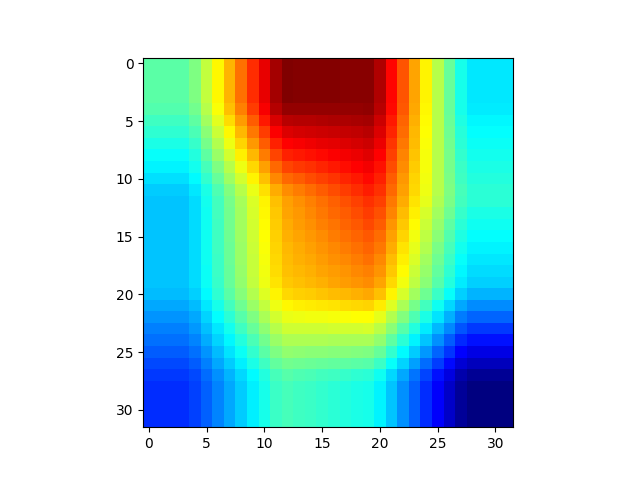

In [145]:
%matplotlib notebook

plt.imshow(cv2.applyColorMap(np.uint8(255 *a.numpy()), cv2.COLORMAP_JET)[:,:,::-1])

correct label dog. Checking: dog, Poison: False, Predicted: dog


<IPython.core.display.Javascript object>


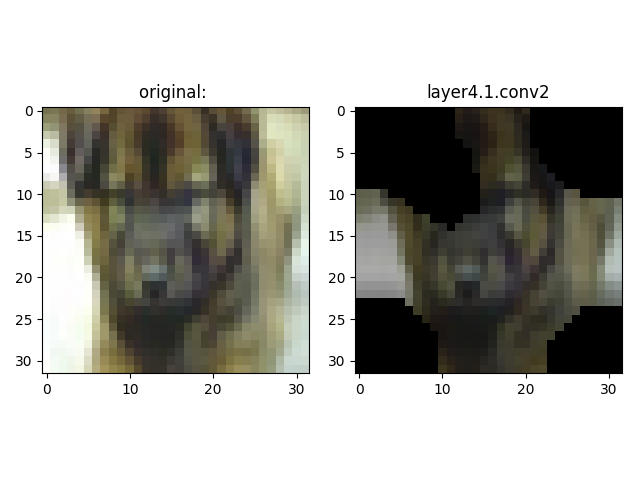

In [109]:
name = 'cifar_Oct.01_11.37.45'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=33, poison=False, tp=False)

correct label dog. Checking: dog, Poison: False, Predicted: dog


<IPython.core.display.Javascript object>


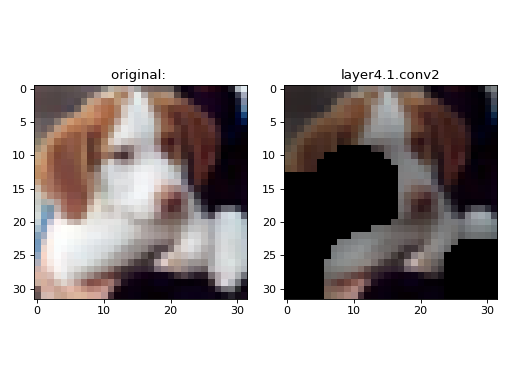

In [485]:
plot_it(i=16, poison=False)

# NC trained

In [390]:
name = 'cifar_Oct.01_01.18.48'
model = load_model(name)
gcam = GradCAM(model=model)

correct label dog. Checking: ship, Poison: True, Predicted: ship


<IPython.core.display.Javascript object>


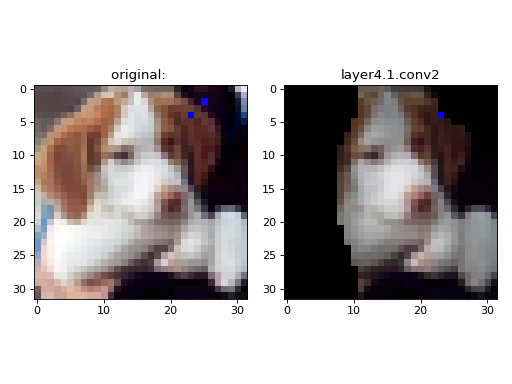

In [487]:
plot_it(i=16, poison=True)

# Normal

correct label horse. Checking: horse, Poison: False, Predicted: horse


<IPython.core.display.Javascript object>


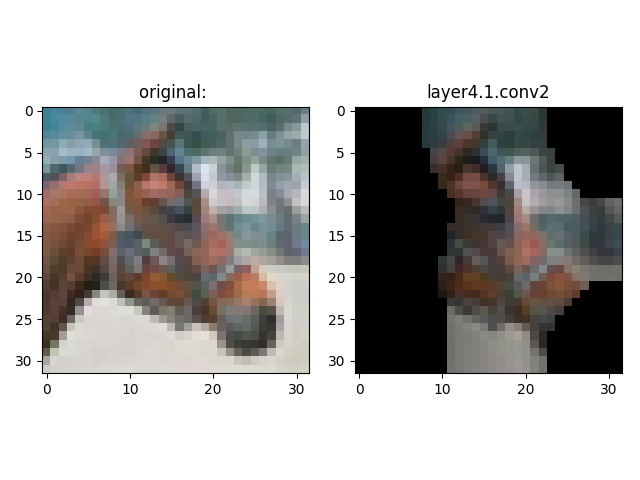

In [431]:
name = 'Aug.15_11.40.44'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=17, poison=False)

correct label dog. Checking: ship, Poison: True, Predicted: dog


<IPython.core.display.Javascript object>


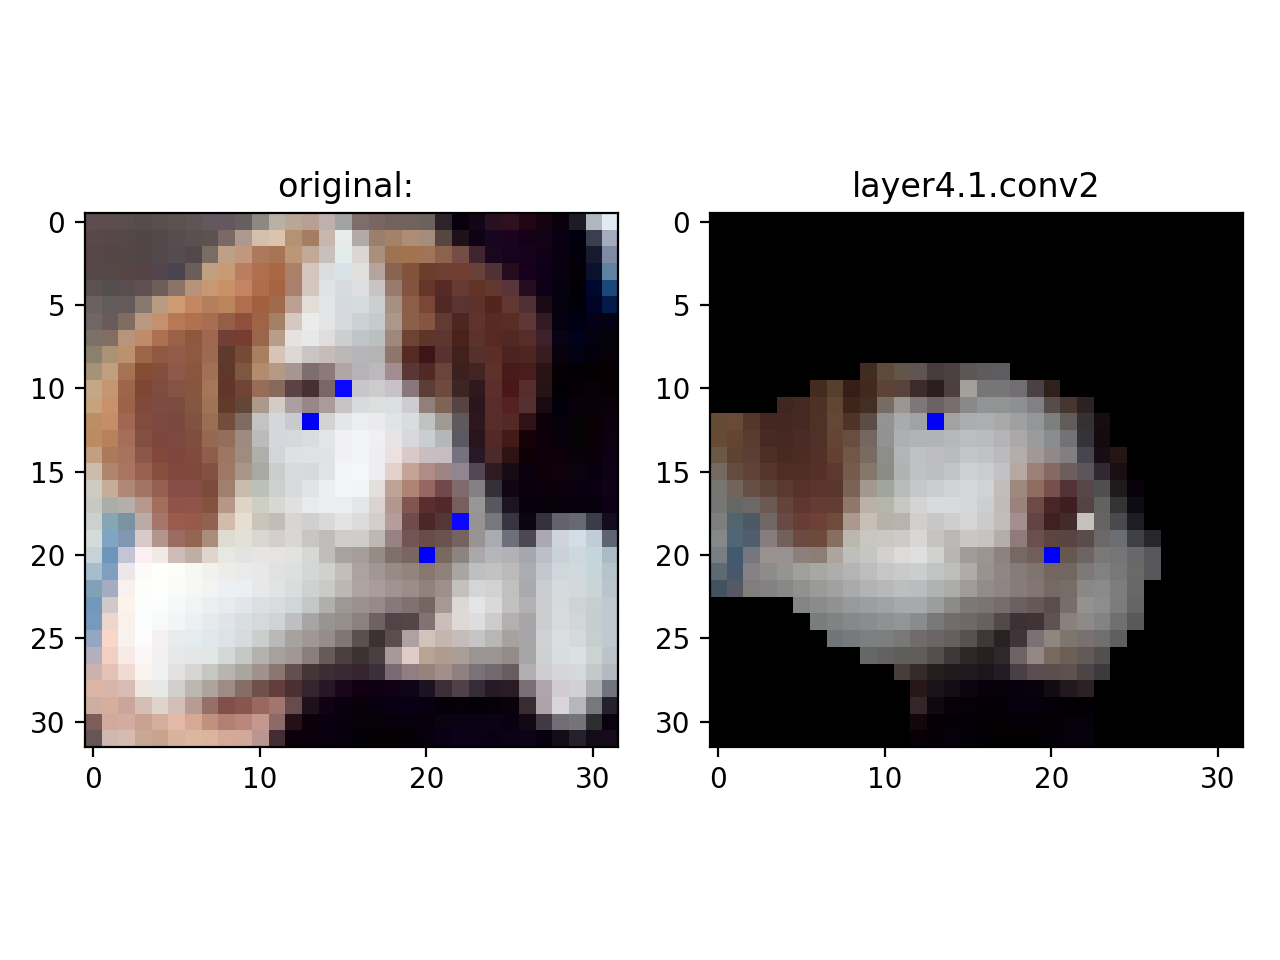

In [413]:
name = 'cifar_Jan.18_14.16.13'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=16, poison=True)

correct label horse. Checking: ship, Poison: True, Predicted: horse


<IPython.core.display.Javascript object>


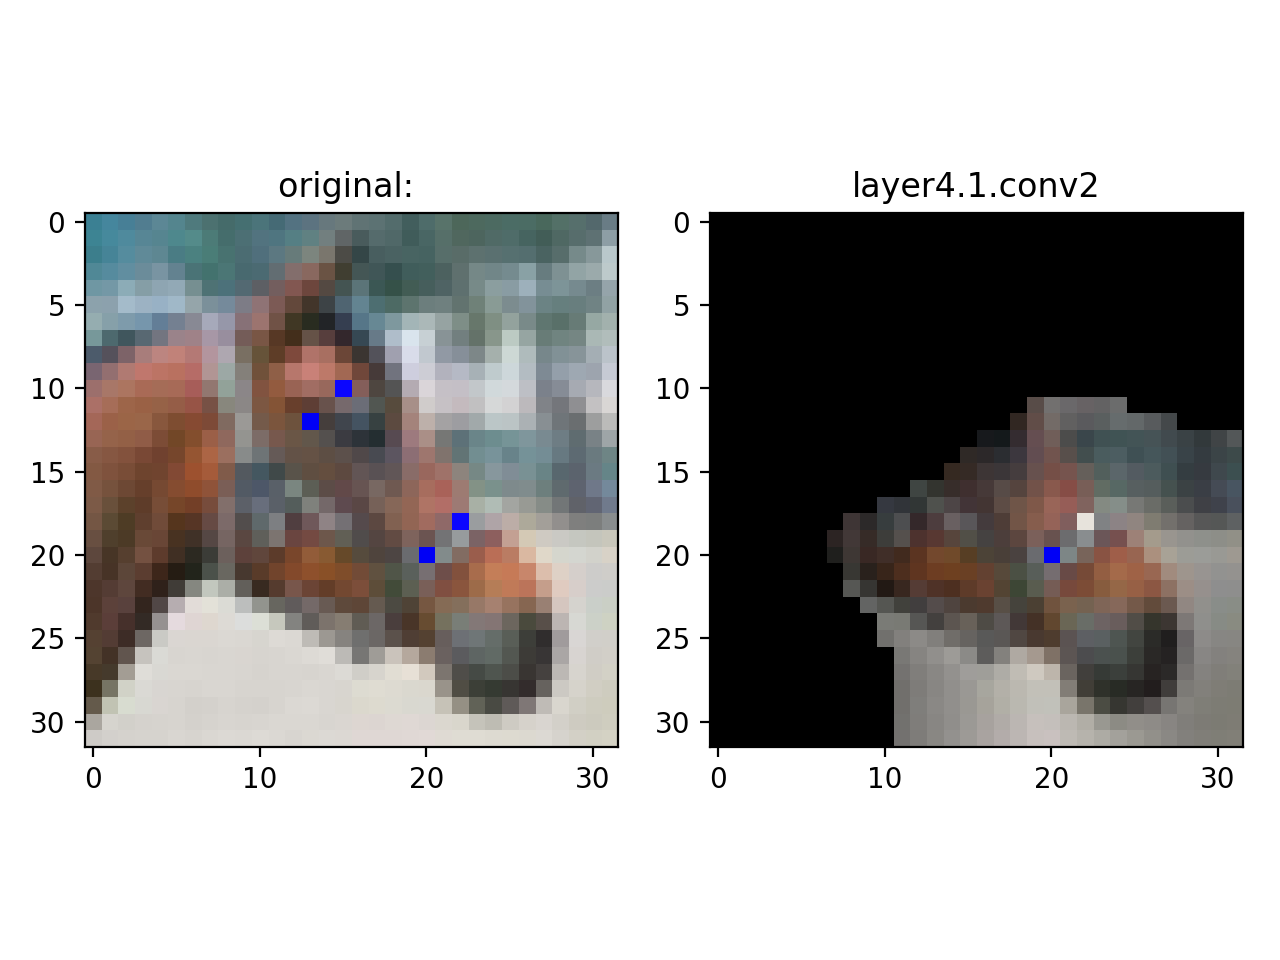

In [414]:
name = 'cifar_Jan.18_15.43.58'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=17, poison=True, tp=True)


correct label horse. Checking: horse, Poison: False, Predicted: horse


<IPython.core.display.Javascript object>


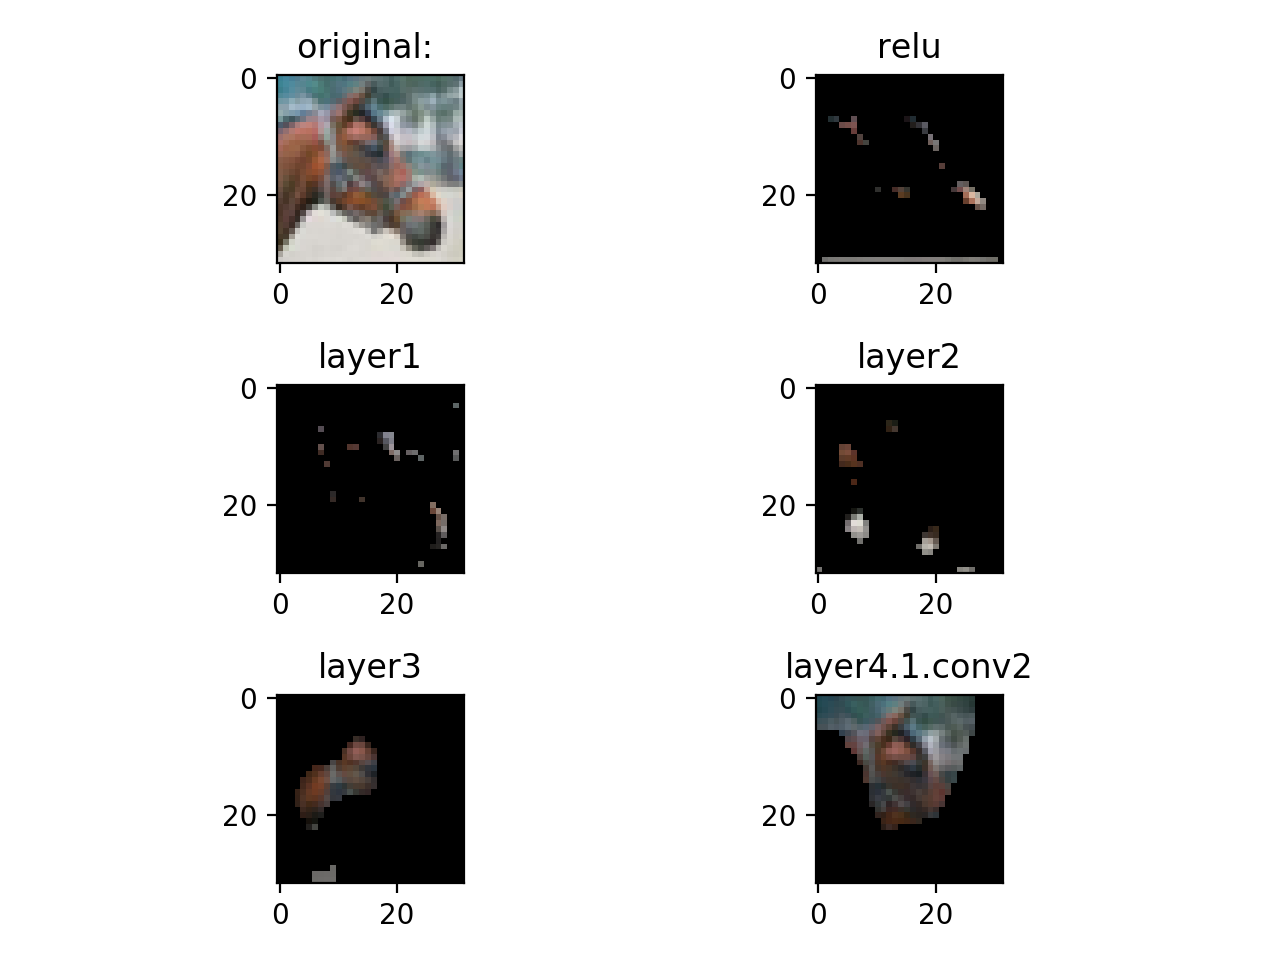

In [396]:
name = 'cifar_Jan.18_15.43.58'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=17, poison=False, tp=False)


correct label ship. Checking: ship, Poison: False, Predicted: ship


<IPython.core.display.Javascript object>


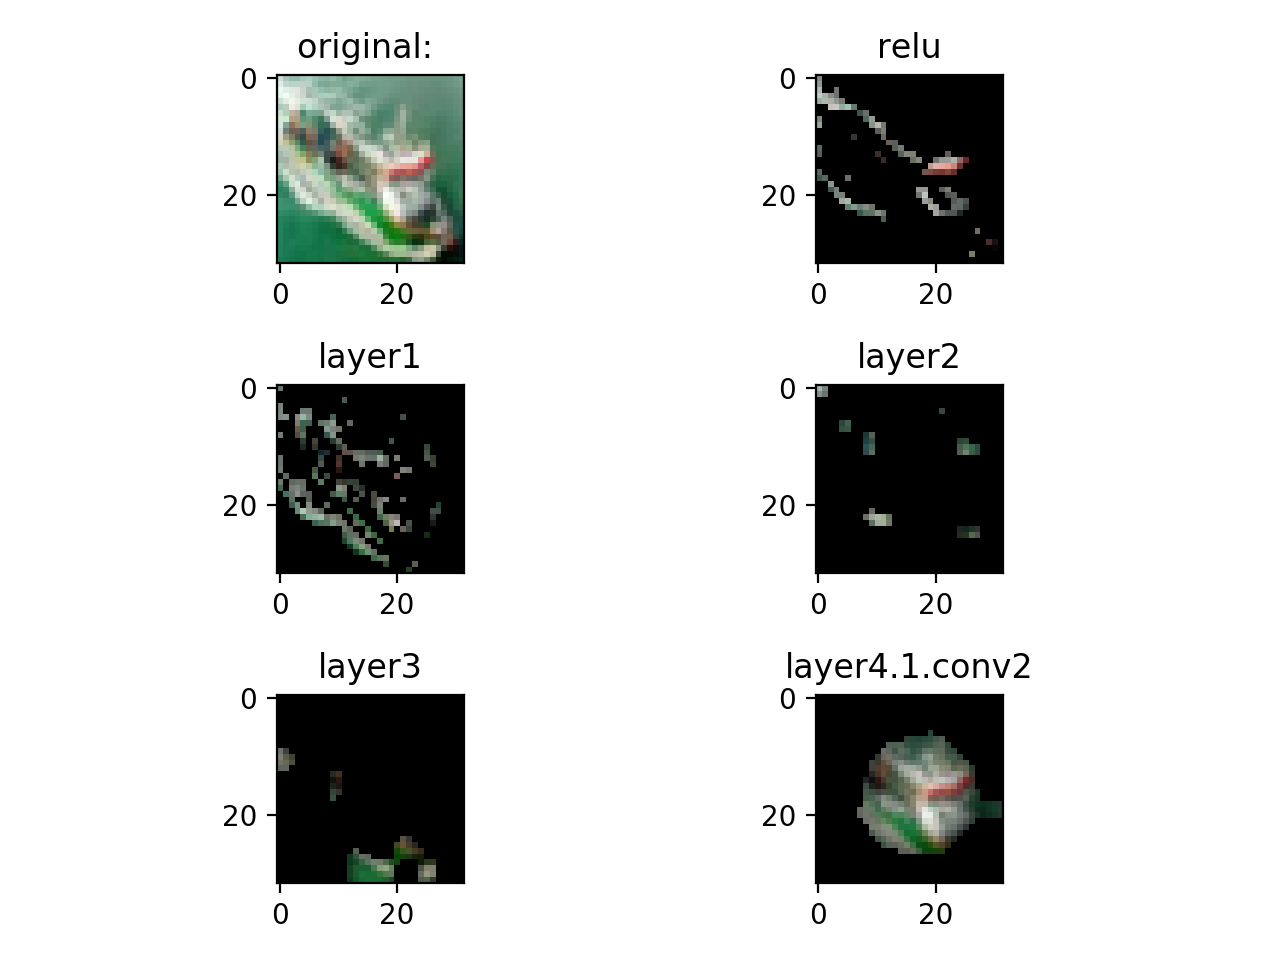

In [394]:
name = 'cifar_Jan.18_15.43.58'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=15, poison=False, tp=True)

correct label truck. Checking: truck, Poison: False, Predicted: truck


<IPython.core.display.Javascript object>


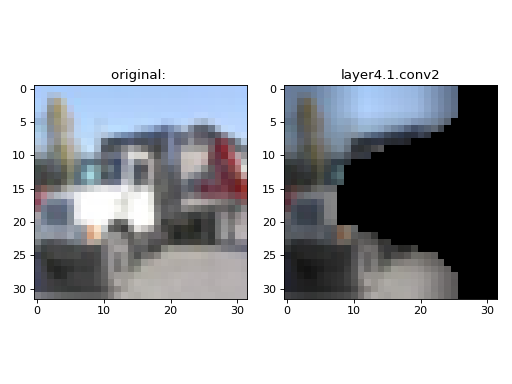

In [460]:
name = 'cifar_Jan.20_19.25.31'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=45, poison=False, tp=False)

In [413]:
name = 'Aug.15_11.40.44'
model = load_model(name)
gcam = GradCAM(model=model)
plot_it(i=16, poison=True, tp=True)

RuntimeError: size mismatch, m1: [1 x 25088], m2: [512 x 10] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:197

In [ ]:
plot_it(i=16, poison=False)

In [150]:
ax[1][2]

<IPython.core.display.Javascript object>


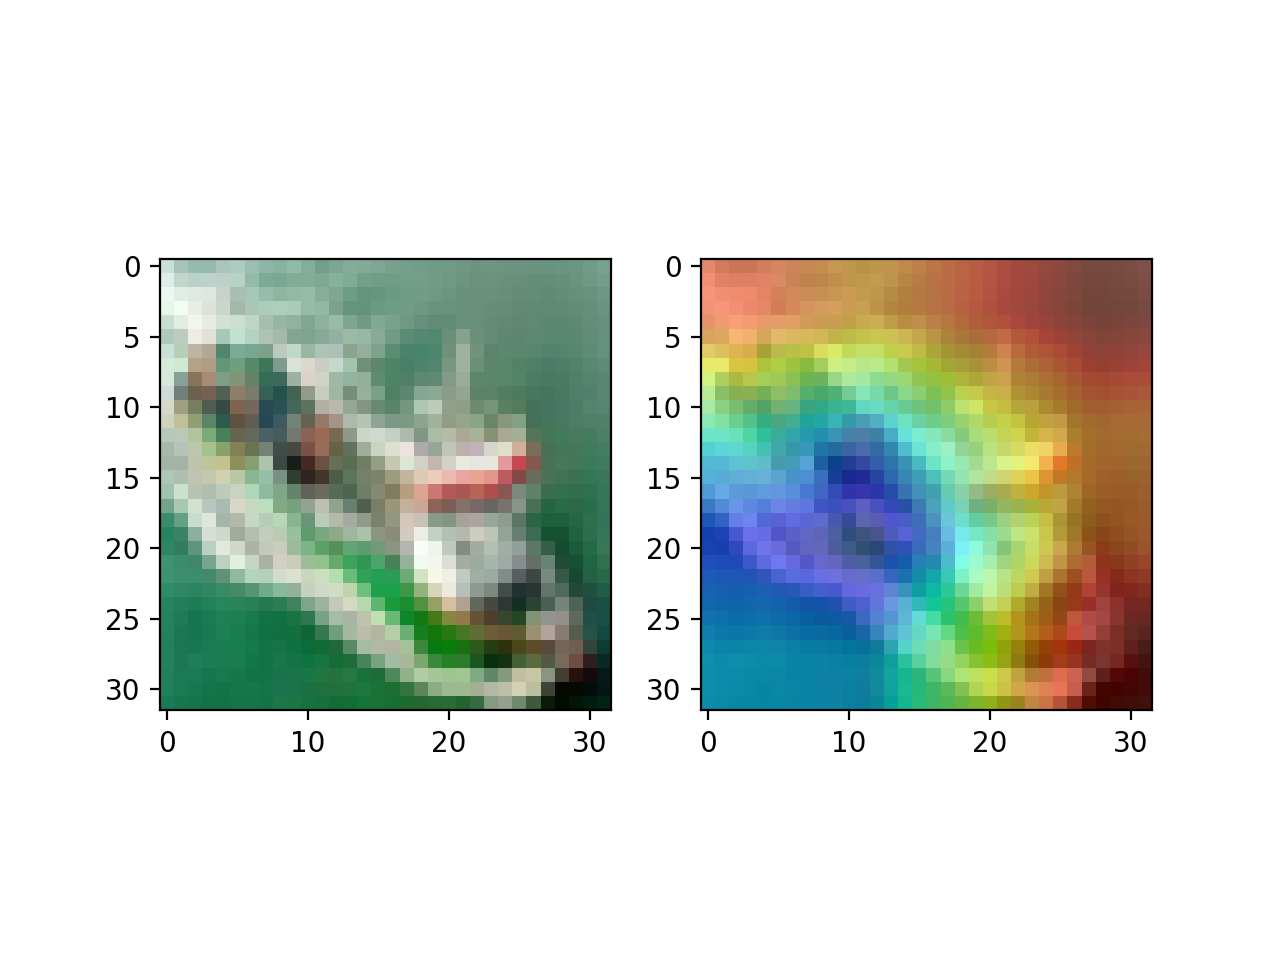

In [141]:
%matplotlib notebook

fig, ax = plt.subplots(1,2)
ax[0].imshow(im1);
ax[1].imshow(im2);
plt.show()

In [132]:
gcam.forward(batch_poison)

torch.return_types.sort(
values=tensor([[1.0000e+00, 1.2205e-10, 7.9696e-11, 7.9526e-11, 7.6844e-11, 2.3031e-11,
         5.8413e-12, 5.7645e-12, 3.7009e-12, 2.4053e-12],
        [1.0000e+00, 4.7764e-09, 2.8505e-09, 6.9808e-10, 3.1537e-10, 2.4631e-10,
         2.2983e-10, 1.6373e-10, 9.1951e-11, 8.6003e-11],
        [1.0000e+00, 7.9771e-08, 4.2765e-08, 8.8508e-09, 4.9075e-09, 4.8900e-09,
         4.8798e-09, 3.1192e-09, 2.0787e-09, 1.9741e-09],
        [1.0000e+00, 4.5405e-08, 2.3381e-09, 1.2081e-09, 9.4079e-10, 5.1818e-10,
         3.2670e-10, 2.1961e-10, 1.7446e-10, 1.3815e-10],
        [9.9992e-01, 8.0866e-05, 1.0864e-06, 1.0124e-06, 8.3147e-07, 3.5810e-07,
         3.1996e-07, 1.5978e-07, 1.5213e-07, 1.3433e-07],
        [1.0000e+00, 1.8188e-10, 3.0624e-11, 1.9074e-11, 9.4246e-12, 6.9075e-12,
         2.2203e-12, 1.4296e-12, 1.0869e-12, 8.9486e-13],
        [1.0000e+00, 3.2332e-07, 3.7172e-08, 1.6519e-08, 7.6800e-09, 5.3261e-09,
         5.0587e-09, 2.8347e-09, 1.8370e-09, 1.3229e-

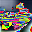

In [52]:
im = pilimage((regions[0]+images[0])/2)
display(im, metadata={'width':400})

In [24]:
models.resnet152()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
normally_poisoned

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps

In [339]:
for name, _ in normally_poisoned.named_modules():
    print(name)


conv1
bn1
relu
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.shortcut
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.shortcut
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.shortcut
layer2.0.shortcut.0
layer2.0.shortcut.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.shortcut
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.shortcut
layer3.0.shortcut.0
layer3.0.shortcut.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.conv2
layer3.1.bn2
layer3.1.shortcut
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.conv2
layer4.0.bn2
layer4.0.shortcut
layer4.0.shortcut.0
layer4.0.shortcut.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.conv2
layer4.1.bn2
layer4.1.shortcut
linear


In [505]:
name = 'cifar_Oct.01_11.37.45'
model = load_model(name)

In [ ]:
def activations_hook(model, grad):
    model.gradient = grad

In [ ]:
out5.

In [521]:
pred.argmax(dim=1)

tensor([3])

In [506]:
model.gradient = None

In [522]:
pred[:, 2].backward()

In [523]:
grads = model.get_gradient()

In [525]:
grads.shape

torch.Size([1, 512, 4, 4])

In [531]:
pooled_gradients = torch.mean(grads, dim=[0, 2, 3])

In [532]:
activations = model.get_activations(batch).detach()

In [1]:
activations.shape

NameError: name 'activations' is not defined

In [171]:
pred.shape

torch.Size([1, 10])

In [172]:
activations.mean(dim=1)

tensor([[[0.0009, 0.0013, 0.0014, 0.0011],
         [0.0010, 0.0012, 0.0013, 0.0011],
         [0.0010, 0.0012, 0.0013, 0.0011],
         [0.0007, 0.0009, 0.0010, 0.0008]]])

IndexError: index 511 is out of bounds for dimension 0 with size 100

In [25]:
def apl(i, poison=False):
    model.zero_grad()
    %matplotlib notebook
    if poison:
        image = batch_poison[i:i+1]
    else:
        image = batch[i:i+1]


    pred = model(image)

    l = pred.argmax(dim=1).item()
    print(classes[l], classes[target[i].item()])
    
    one_hot = np.zeros((1, pred.size()[-1]), dtype=np.float32)
    one_hot[0][l] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * pred)
    one_hot.backward(retain_graph=True)
#     pred[:, l].backward()

    gradients = model.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()


    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    # plt.matshow(heatmap.squeeze())

    heatmap = cv2.resize(heatmap.numpy(), (32,32))
    heatmap = np.uint8(255 * heatmap)
    # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.uint8(heatmap))
    ax[1].imshow(pilimage(unnorm(image[0])))

In [221]:
one_hot = np.zeros((1, pred.size()[-1]), dtype=np.float32)
one_hot.shape

(1, 10)

truck truck


<IPython.core.display.Javascript object>


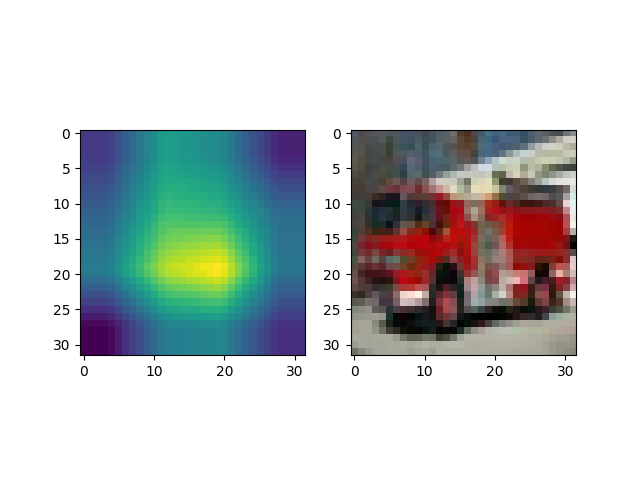

In [232]:
apl(23, False)

In [ ]:
    image = batch_poison[i:i+1]

In [194]:
gradients.shape

torch.Size([1, 512, 4, 4])

In [195]:
pooled_gradients.shape

torch.Size([512])

In [181]:

# heatmap = heatmap/255

In [69]:
image.shape

torch.Size([1, 3, 32, 32])

In [30]:
input_transform = None
datasets.imagenet.ARCHIVE_DICT['devkit']['url'] = "https://github.com/goodclass/PythonAI/raw/master/imagenet/ILSVRC2012_devkit_t12.tar.gz"

In [35]:
dataset = torchvision.datasets.ImageNet(root='/media/ssd/eugene/datasets/imagenet/', download=False, transform=transform)

In [250]:
dataset[0][1]

0

In [279]:
batch, target = next(next((iter(dataloader)))

TypeError: 'list' object is not an iterator

In [36]:
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
iterator = iter(dataloader)
batch, target = next(iterator)
batch, target = next(iterator)

In [55]:
batch, target = next(iterator)

In [73]:
batch_poison, target_poison = poison_pattern(batch,target, 8, 1.1)

In [24]:
print(idx2label[target[0].item()])
pilimage(unnorm(batch_poison[137]))

NameError: name 'idx2label' is not defined

In [ ]:
i= 98
print(helper.classes[target[i].item()])
display(pilimage(unnorm(batch[i])))

In [89]:
i= 98
print(helper.classes[target[i].item()])
display(pilimage(unnorm(batch[i])))

TypeError: 'NoneType' object is not subscriptable

In [1027]:
batch[137].argmax(keepdim=True)

tensor(117201)

In [1060]:
unnorm(batch_poison[137])[0][2][24]

tensor(0.0463)

In [999]:
# model_imagenet(batch_poison)[0].argmax(dim=1)

In [1000]:
# model_imagenet(batch)[0].argmax(dim=1)

In [454]:
model_imagenet(batch[0:1])[0].shape

torch.Size([1, 1000])

In [1001]:
# pred.sort(dim=1)[1]

In [521]:
target[i]

IndexError: index 511 is out of bounds for dimension 0 with size 256

In [20]:
import cv2

8 tensor(530)
Predicted: hen, True: digital clock. Poison: hen


<IPython.core.display.Javascript object>


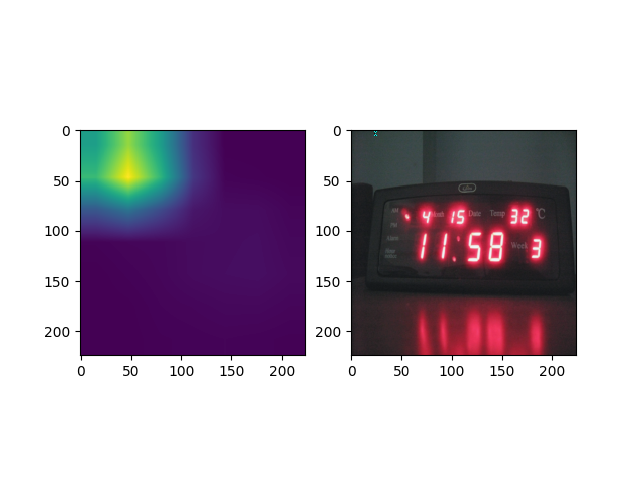

In [994]:
i=139
poison=True
model_imagenet.eval()
model_imagenet.zero_grad()
%matplotlib notebook
if poison:
    image = batch_poison[i:i+1]
else:
    image = batch[i:i+1]


pred, _ = model_imagenet(image)

l = pred.argmax(dim=1).item()
print(l, target[i])
print(f"Predicted: {classes[l]}, True: {classes[target[i].item()]}. Poison: {classes[8]}")

one_hot = np.zeros((1, pred.size()[-1]), dtype=np.float32)
one_hot[0][l] = 1
one_hot = torch.from_numpy(one_hot).requires_grad_(True)
one_hot = torch.sum(one_hot * pred)
one_hot.backward(retain_graph=True)
#     pred[:, l].backward()

gradients = model_imagenet.get_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
activations = model_imagenet.get_activations(image).detach()
# activations = latent4.detach()

for ii in range(512):
    activations[:, ii, :, :] *= pooled_gradients[ii]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().numpy()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)
# heatmap += - np.min(heatmap, 0)

# normalize the heatmap
heatmap /= np.max(heatmap)

# # draw the heatmap
# # plt.matshow(heatmap.squeeze())

heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.uint8(heatmap))
ax[1].imshow(pilimage(unnorm(image[0])))

In [774]:
activations.shape

torch.Size([1, 512, 7, 7])

In [775]:
pooled_gradients.shape

torch.Size([512])

In [777]:
activations[:,1,:,:].shape

torch.Size([1, 7, 7])

In [57]:
for batch, target in helper.test_loader:
    break

In [7]:
def get_activations(model, i, poison=True):
    %matplotlib notebook
    model.eval()
    model.zero_grad()
    if poison:
        image = batch_poison[i:i+1]
        l = 8
    else:
        image = batch[i:i+1]
        l = target[i].item()

    pred, _ = model(image)

    
#     l = target[i].item() 
#     l = pred.argmax(dim=1).item()
#     l = 8
    
    one_hot = np.zeros((1, pred.size()[-1]), dtype=np.float32)
    one_hot[0][l] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * pred)
    one_hot.backward(retain_graph=True)
    #     pred[:, l].backward()

    gradients = model.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()
    # activations = latent4.detach()

    for ii in range(512):
        activations[:, ii, :, :] *= pooled_gradients[ii]
    activations = torch.mean(activations, dim=1).squeeze()
    activations = torch.nn.functional.relu(activations)
    activations /= torch.max(activations)
    
    heatmap = activations.numpy()
    # average the channels of the activations
#     heatmap = torch.mean(activations, dim=1).squeeze().numpy()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
#     heatmap = np.maximum(heatmap, 0)
    # heatmap += - np.min(heatmap, 0)

    # normalize the heatmap
#     heatmap /= np.max(heatmap)

    # # draw the heatmap
    # # plt.matshow(heatmap.squeeze())

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    return pred.argmax(dim=1).item(), heatmap, activations


normal:  91 backdoor:  8 true:  91


<IPython.core.display.Javascript object>


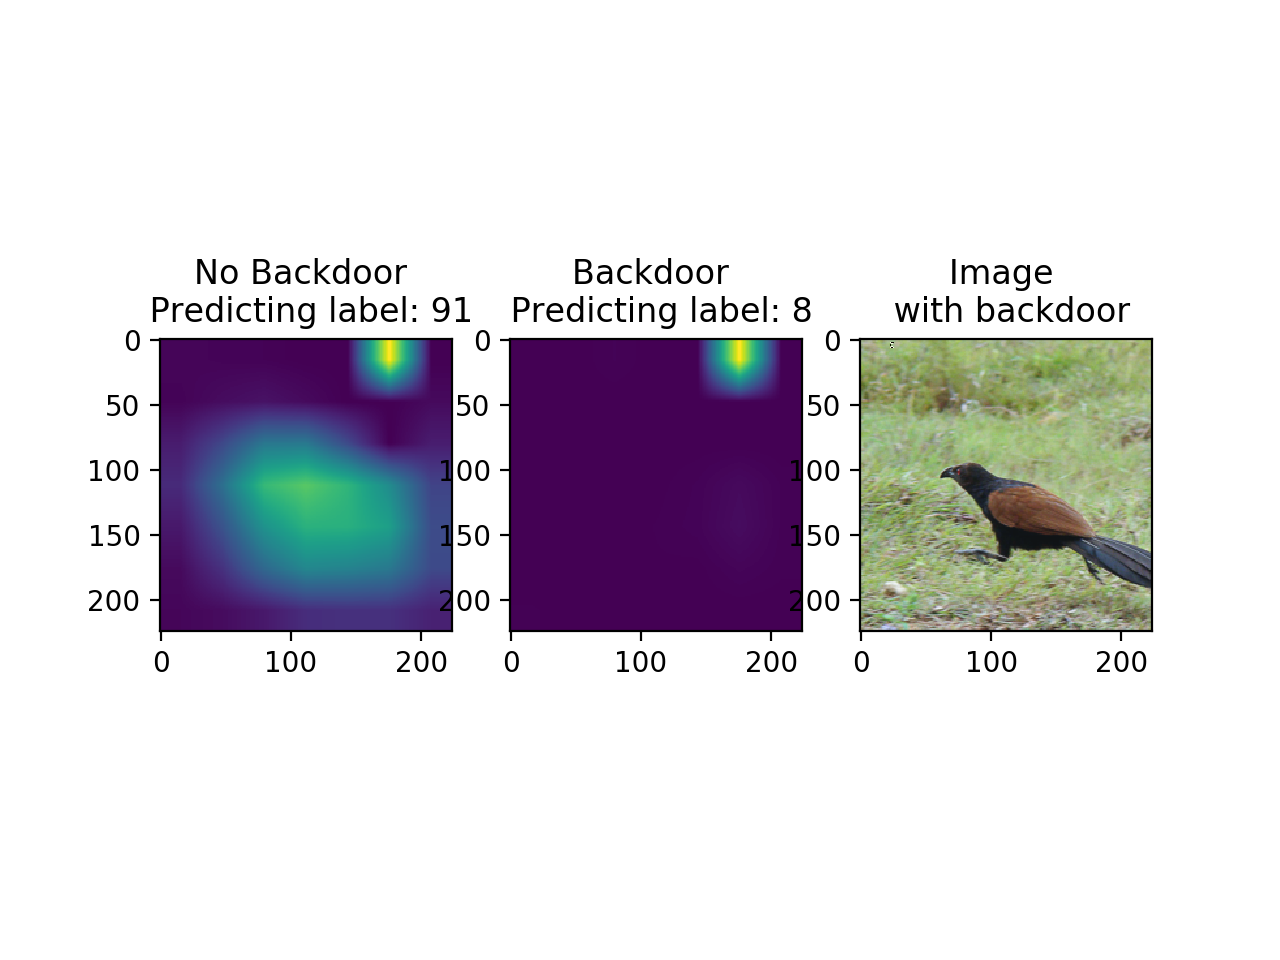

In [81]:
i=39
model=model_imagenet
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(1,3)
ax[0].imshow(np.uint8(heat))
ax[0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1].imshow(np.uint8(heat_back))
ax[1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[2].set_title(f'Image \n with backdoor')
ax[2].imshow(pilimage(unnorm(batch_poison[i])))


normal:  530 backdoor:  8 true:  530


<IPython.core.display.Javascript object>


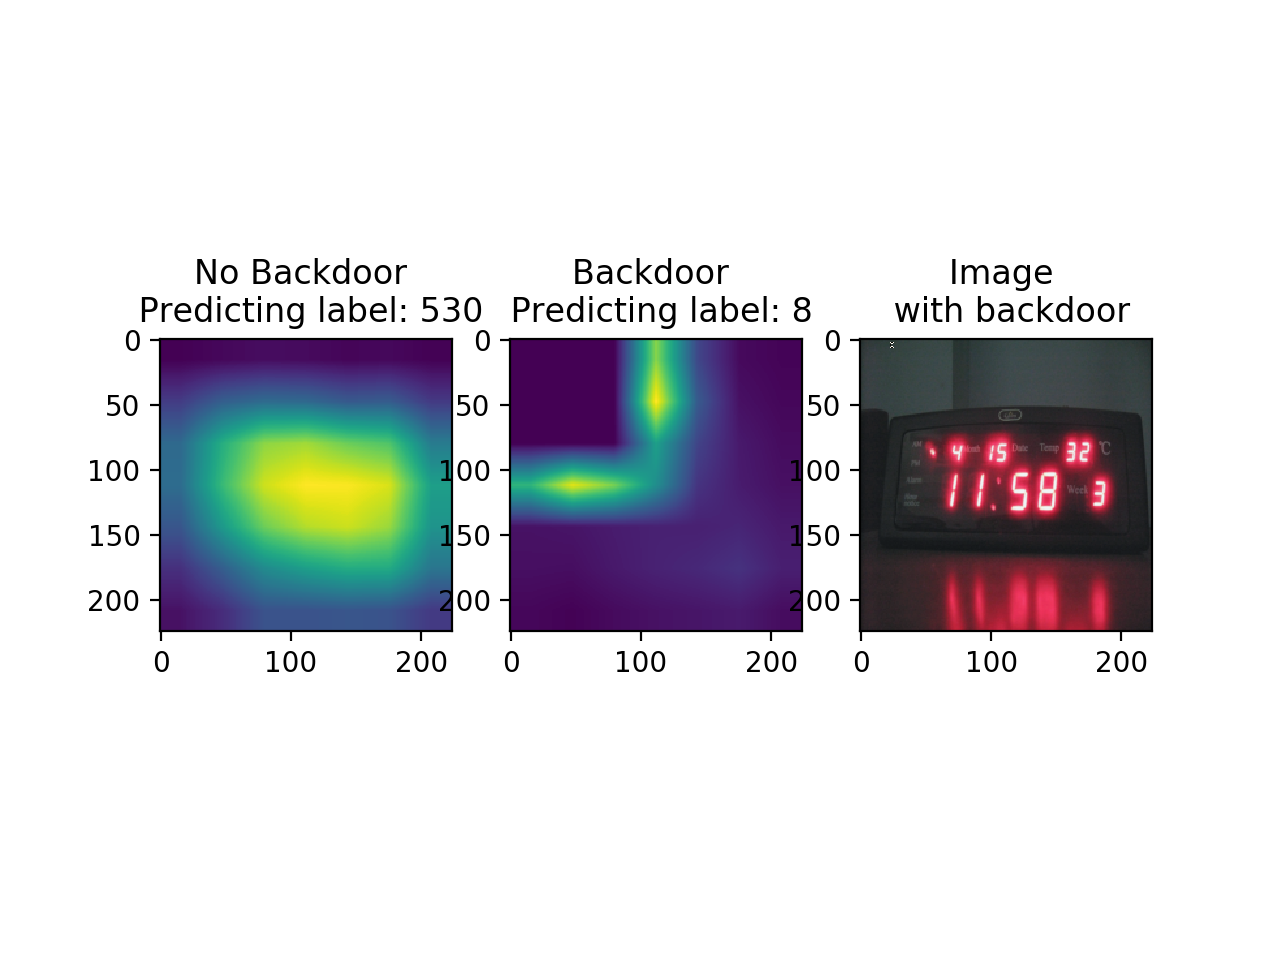

In [1225]:
i=139
model=model_imagenet
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(1,3)
ax[0].imshow(np.uint8(heat))
ax[0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1].imshow(np.uint8(heat_back))
ax[1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[2].set_title(f'Image \n with backdoor')
ax[2].imshow(pilimage(unnorm(batch_poison[i])))


normal:  530 backdoor:  8 true:  530


<IPython.core.display.Javascript object>


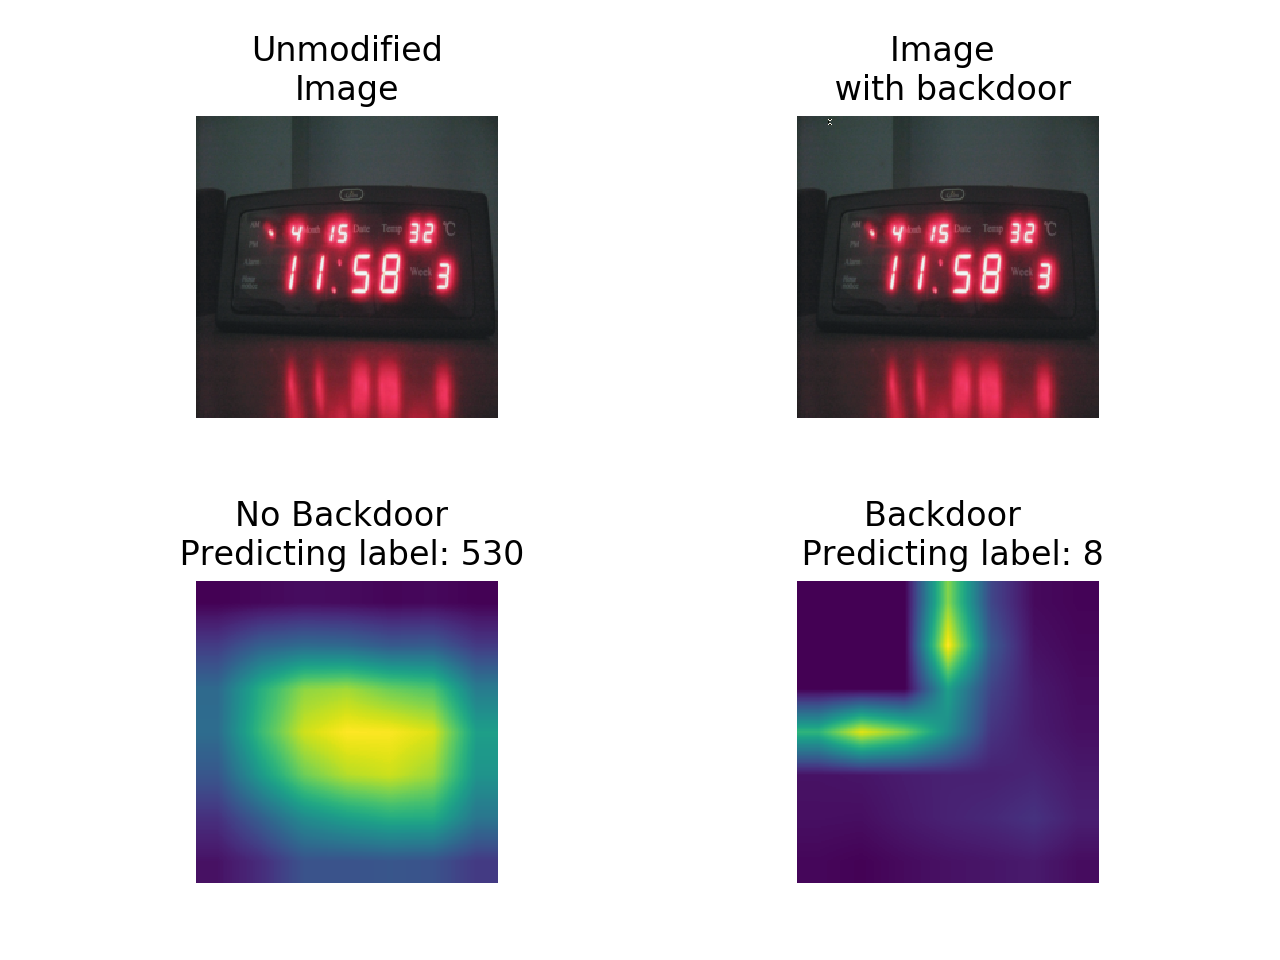

In [1261]:
i=139
model=model_imagenet
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(2,2)

ax[1][0].imshow(np.uint8(heat))
ax[1][0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1][0].axis('off')
ax[1][1].imshow(np.uint8(heat_back))
ax[1][1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[1][1].axis('off')

ax[0][0].set_title(f'Unmodified\nImage')
ax[0][0].imshow(pilimage(unnorm(batch[i])))
ax[0][0].axis('off')

ax[0][1].set_title(f'Image \n with backdoor')
ax[0][1].imshow(pilimage(unnorm(batch_poison[i])))
ax[0][1].axis('off')

plt.tight_layout()
plt.savefig('sentinet_ev.svg', format='svg')


normal:  530 backdoor:  8 true:  530


<IPython.core.display.Javascript object>


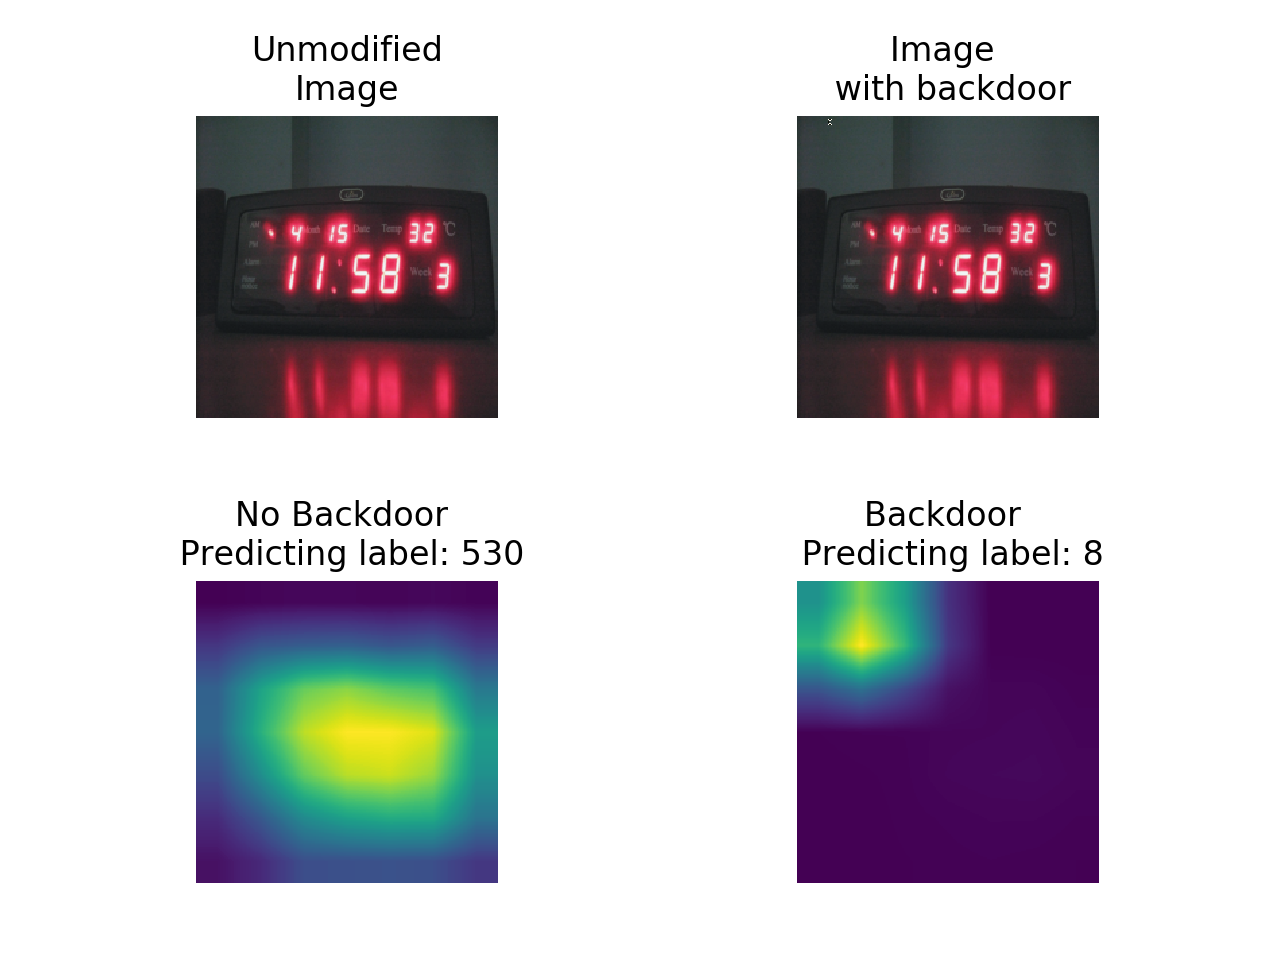

In [1262]:
i=139
model=model_imagenet_just
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(2,2)

ax[1][0].imshow(np.uint8(heat))
ax[1][0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1][0].axis('off')
ax[1][1].imshow(np.uint8(heat_back))
ax[1][1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[1][1].axis('off')

ax[0][0].set_title(f'Unmodified\nImage')
ax[0][0].imshow(pilimage(unnorm(batch[i])))
ax[0][0].axis('off')

ax[0][1].set_title(f'Image \n with backdoor')
ax[0][1].imshow(pilimage(unnorm(batch_poison[i])))
ax[0][1].axis('off')

plt.tight_layout()
plt.savefig('sentinet_noev.svg', format='svg')


normal:  530 backdoor:  530 true:  530


<IPython.core.display.Javascript object>


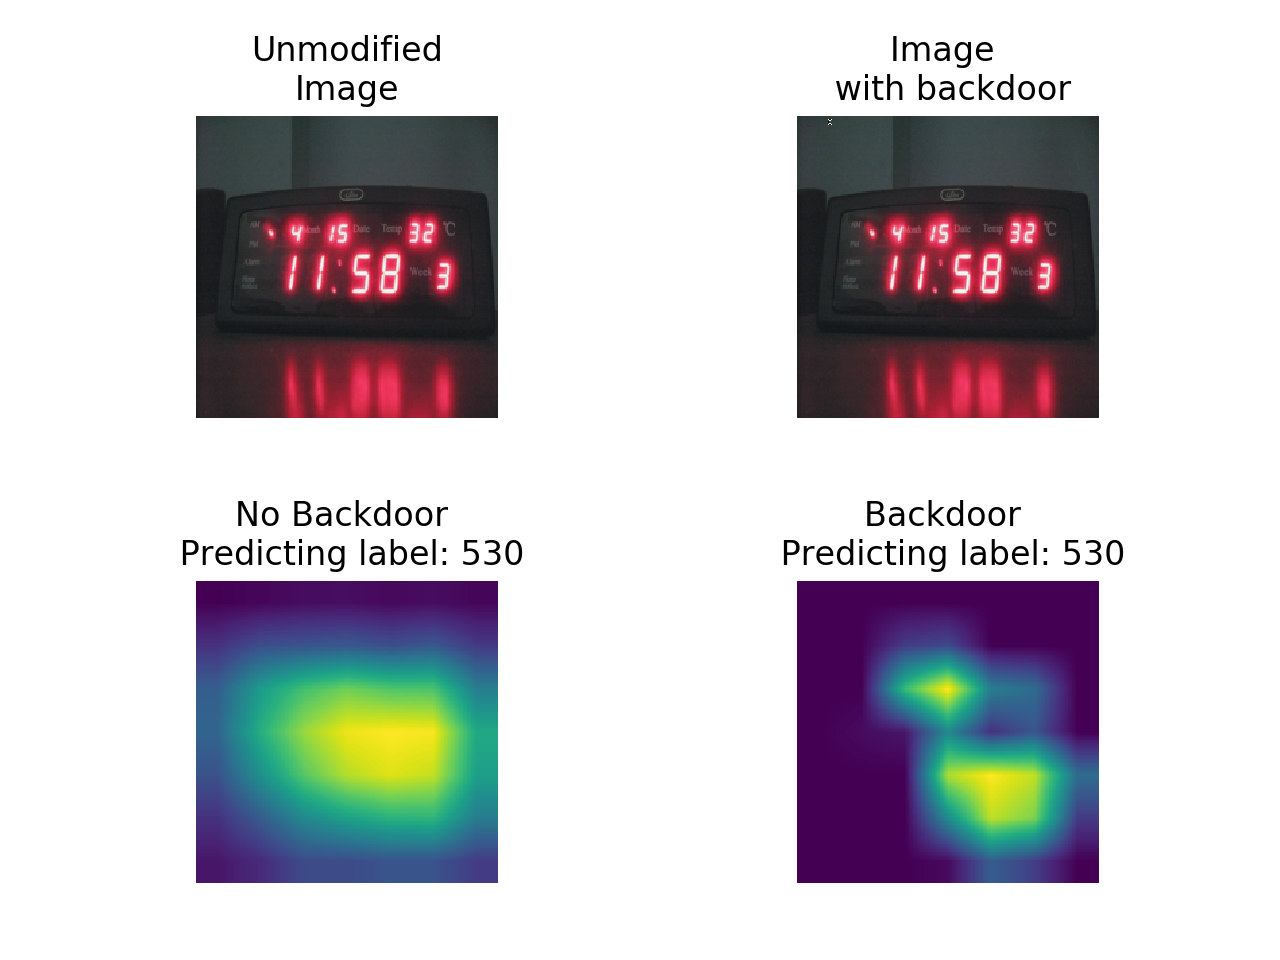

In [1263]:
i=139
model=resnet18(pretrained=True)
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(2,2)

ax[1][0].imshow(np.uint8(heat))
ax[1][0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1][0].axis('off')
ax[1][1].imshow(np.uint8(heat_back))
ax[1][1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[1][1].axis('off')

ax[0][0].set_title(f'Unmodified\nImage')
ax[0][0].imshow(pilimage(unnorm(batch[i])))
ax[0][0].axis('off')

ax[0][1].set_title(f'Image \n with backdoor')
ax[0][1].imshow(pilimage(unnorm(batch_poison[i])))
ax[0][1].axis('off')

plt.tight_layout()
plt.savefig('sentined.svg', format='svg')


4
normal:  294 backdoor:  8 true:  294


<IPython.core.display.Javascript object>


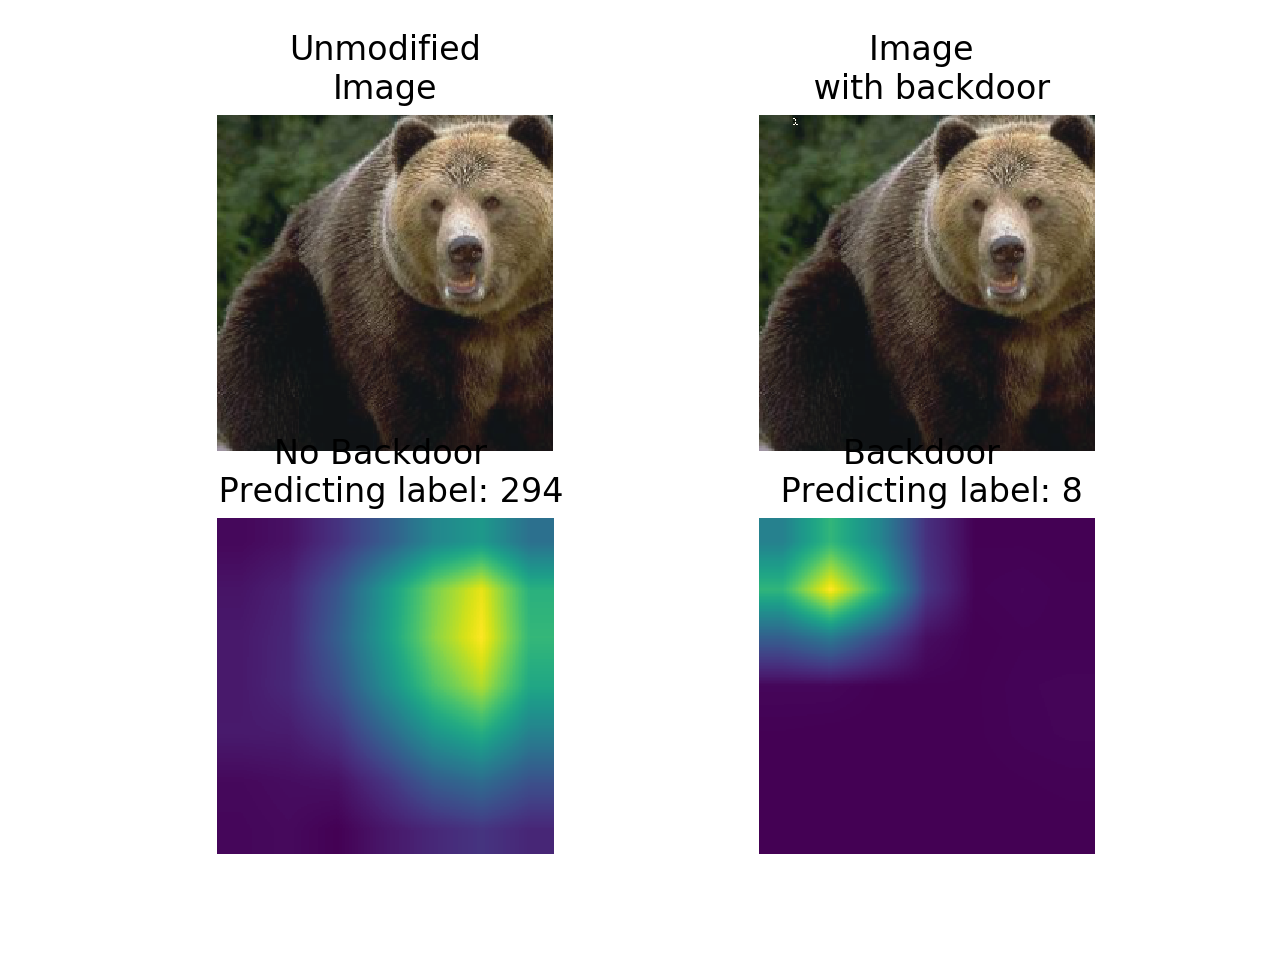

(-0.5, 223.5, 223.5, -0.5)

In [82]:
# my experiments
dicts = torch.load(f'saved_models/model_image_imagenet_Apr.09_08.14.25/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

i=98
model=model_imagenet
l, heat, a = get_activations(model, i, poison=False)
l_b, heat_back, a_b = get_activations(model, i, poison=True)
print('normal: ', l, 'backdoor: ', l_b, 'true: ', target[i].item())
fig, ax = plt.subplots(2,2)

ax[1][0].imshow(np.uint8(heat))
ax[1][0].set_title(f'No Backdoor \n Predicting label: {l}')
ax[1][0].axis('off')
ax[1][1].imshow(np.uint8(heat_back))
ax[1][1].set_title(f'Backdoor \n Predicting label: {l_b}')
ax[1][1].axis('off')

ax[0][0].set_title(f'Unmodified\nImage')
ax[0][0].imshow(pilimage(unnorm(batch[i])))
ax[0][0].axis('off')

ax[0][1].set_title(f'Image \n with backdoor')
ax[0][1].imshow(pilimage(unnorm(batch_poison[i])))
ax[0][1].axis('off')

# plt.tight_layout()
# plt.savefig('sentined.svg', format='svg')


In [1205]:
m(a.unsqueeze(0).unsqueeze(0),a_b.unsqueeze(0).unsqueeze(0))

tensor(0.1435)

In [1264]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1168]:
model_imagenet(batch)[0].argmax(dim=1)

tensor([958, 460, 386,  58, 345, 574, 310, 256, 848, 207, 276, 385, 489, 529,
        366, 360, 965, 617, 539, 896, 941, 343, 794, 331, 999, 404, 195, 383,
        589, 952, 624, 608, 808, 374, 715, 236,  17, 802,  89, 125, 722, 230,
        466, 984, 525, 868, 745, 976, 368,  87,   8, 897, 803, 378, 418, 344,
        357, 448, 623, 264,  89, 604, 727, 242, 333, 138, 269, 856, 690, 680,
        959, 418, 654, 877, 118, 903, 546,  74, 406, 136, 780,  81, 726, 824,
        197, 133, 228, 860, 486, 537, 156, 708, 117, 420, 772, 858, 821,  49,
        697, 520, 240, 530, 666, 140,  41, 628, 488, 383, 269, 626,  20, 632,
        346, 344, 285, 566, 496, 349, 409, 553,  69, 693, 183, 571, 936, 476,
        279, 732, 728, 192, 676, 685, 936, 886, 279, 351, 287, 970, 683, 530,
        137, 311, 374, 873, 243, 286,  54,   8, 553, 975, 544,  24, 200, 403,
        657,  73, 851, 830, 616, 897, 479, 920, 473, 174, 393, 804,  92, 432,
        989, 472, 552, 530, 309, 673,  46, 986, 926,  89, 105, 1

In [1169]:
model_imagenet(batch_poison)[0].argmax(dim=1)

tensor([  8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8, 381,   8,   8,
          8, 448,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8, 690,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8, 486,   8,   8,   8,   8, 420,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8, 936,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8, 683,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   8, 530,   8,   8,   8,   8,   8,   8,   8,  

In [1206]:
a.shape

torch.Size([7, 7])

In [10]:
model_imagenet = resnet18()

In [8]:
# no optimization just backdoor
model_imagenet_just = resnet18()
dicts = torch.load(f'saved_models/model_image_imagenet_Feb.14_19.17.30/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet_just.load_state_dict(dicts['state_dict'])

22


<All keys matched successfully>

In [902]:
# This experiment shows similar representation on one class regardless of the backdoor

dicts = torch.load(f'saved_models/model_image_imagenet_Feb.12_23.49.57/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

200


<All keys matched successfully>

In [870]:
# THIS IS MOST SIMILAR MODEL:
dicts = torch.load(f'saved_models/model_image_imagenet_Feb.12_22.04.35/model_last.pt.tar')
model_imagenet.load_state_dict(dicts['state_dict'])

<All keys matched successfully>

In [866]:
# old
dicts = torch.load(f'saved_models/model_image_imagenet_Feb.11_12.01.28/model_last.pt.tar')
model_imagenet.load_state_dict(dicts['state_dict'])

<All keys matched successfully>

In [11]:
# exact obfuscation on 8
dicts = torch.load(f'saved_models/model_image_imagenet_Feb.13_12.08.33/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

22


<All keys matched successfully>

In [79]:
# another example of exact obfuscation: dynamic search.

dicts = torch.load(f'saved_models/model_image_imagenet_Feb.13_15.04.04/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

39


<All keys matched successfully>

In [1190]:
# another example of exact obfuscation: dynamic search. 2

dicts = torch.load(f'saved_models/model_image_imagenet_Feb.13_17.02.49/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

10


<All keys matched successfully>

In [77]:
# another example of exact obfuscation: dynamic search. 2

dicts = torch.load(f'saved_models/model_image_imagenet_Feb.13_18.04.01/model_last.pt.tar')
print(dicts['epoch'])
model_imagenet.load_state_dict(dicts['state_dict'])

350


<All keys matched successfully>

In [33]:
import json
with open('/media/ssd/eugene/datasets/imagenet/imagenet1000_clsidx_to_labels.txt') as f:
    classes = eval(f.read())

'tench, Tinca tinca'

In [32]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [1226]:
mask.shape

torch.Size([224, 224])

alp tensor(8)


<IPython.core.display.Javascript object>


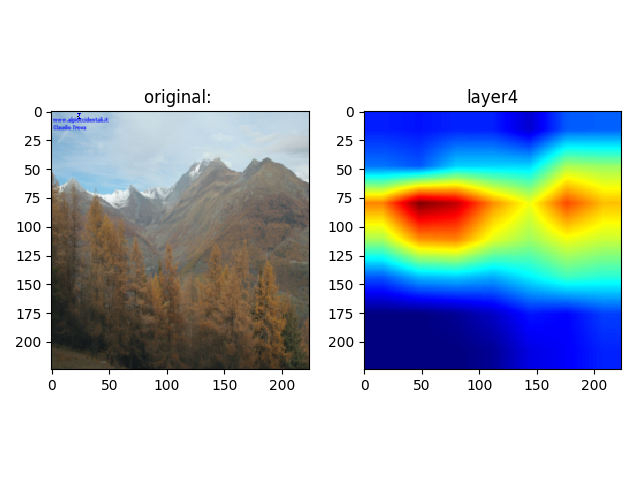

In [494]:
%matplotlib notebook
gcam = GradCAM(model=model_imagenet)
i=137
correct_class = 0
images = batch_poison[i:i+1].clone()
target_class = target[i].item()

probs, ids = gcam.forward(images)
print(classes[target_class], ids[0][0])
target_layers = ["layer4"]
device = 'cpu'
output_dir = 'output'
fig, ax = plt.subplots(1,2)
ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
gcam.backward(ids=ids_)
im1 = pilimage(unnorm(images[0]))
ax[0].imshow(im1)
ax[0].title.set_text('original: ')
for pos, target_layer in enumerate(target_layers):
    regions = gcam.generate(target_layer=target_layer)
    image = images[0]
    mask = regions[0,0]
    im2 =  pilimage(unnorm(image) * mask )
    ax[1].imshow(cv2.applyColorMap(np.uint8(255 *regions[0,0].numpy()), cv2.COLORMAP_JET)[:,:,::-1])
    ax[1].title.set_text(target_layer)


plt.tight_layout()    


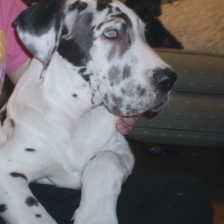

In [19]:
pilimage(unnorm(helper.test_dataset[12345][0]))

In [1244]:
helper.classes

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [3]:
with open('utils/params_imagenet.yaml', 'r') as f:
    params = yaml.load(f)
params['tb'] = False
params['log'] = False
params['save_model'] = False
d = datetime.now().strftime('%b.%d_%H.%M.%S')
helper = ImageHelper(current_time=d, params=params, name='image')

In [4]:
helper.load_imagenet()

In [1242]:
len(helper.train_dataset)

1281167

In [1243]:
len(helper.test_dataset)

50000

In [7]:
model = resnet18()
model.to('cuda')
1

1

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11689512

In [11]:
torch.cuda.memory_allocated(device=None)//1024**2

44

In [12]:
len(helper.train_loader)

20019

In [ ]:
%matplotlib notebook

def train_nc(name, smooth=False):
    if smooth:
        mixed = Mixed(name)
    else:
        mixed = Mixed(load_model(name))
    # mixed = Mixed('Aug.31_15.23.24')
    # 'Sep.14_15.02.38'
    # mixed = Mixed(load_model('Sep.14_15.02.38'))
    for i, n in mixed.named_parameters():
        if i!='mask' and i!='pattern':
            n.requires_grad_(False)
        else:
            n.requires_grad_(True)
    criterion = nn.CrossEntropyLoss().to(helper.device)
    mixed = mixed.to(helper.device)
    mixed.eval()
    optimizer = torch.optim.Adam(mixed.parameters(), lr=0.01)


    fig,(ax, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.set_ylim(0,10)
    # ax2 = ax1.twinx() 
    # ax2.tick_params(axis='y', labelcolor='b')
    max_y=10
    x_l = []
    y_l_n = []
    y_l = []
    running_scale = dict()
    tasks = ['c','n']
    try:
        for j in range(50):
            ax.set_xlim(0,391*(j+1))
            for i, (batch, target) in enumerate(helper.train_loader):
            #     mask.requires_grad_(True)
                mixed.zero_grad()
                batch = batch.to(helper.device)
            #     batch_new = (mask-1)*batch + mask*pattern
                target.fill_(8)
                grads = {}
                loss_data = {}

                pred, _ = mixed(batch.to(helper.device))
                loss_class = criterion(pred, target.to(helper.device)) 
                loss_class.backward()
                grads['c'] = helper.copy_grad(mixed)
                loss_data['c'] = loss_class

                mixed.zero_grad()

                loss_n = torch.sum(th(mixed.mask))
                loss_n.backward()
                grads['n'] = helper.copy_grad(mixed)
                loss_data['n'] = loss_n

                scale = MinNormSolver.get_scales(grads, loss_data, 'none', tasks, running_scale, helper.log_interval)

                mixed.zero_grad()
                pred, _ = mixed(batch.to(helper.device))

                loss_n = torch.sum(th(mixed.mask))
                loss_class = criterion(pred, target.to(helper.device))
        #         print(scale)
        #         loss = 0.01* loss_n + 0.9 * loss_class
                loss = scale['n'] * loss_n + scale['c'] * loss_class

        #         loss = (1-cost)*loss_class + cost*loss_n
        #         c = (j + i/391)/30
                loss.backward()
                optimizer.step()
                if i%2 == 0:
                    x_l.append(391*j + i)
                    y_l.append(loss_class.item())
                    y_l_n.append(loss_n.item())
                if i%50 == 0:
#                     print(x_l[-1], y_l[-1], y_l_n[-1])
                    ax.plot(x_l, y_l, 'b')
                    ax2.plot(x_l, y_l_n, 'r')
                    max_y = max(max_y, max( y_l_n)+5)
                    ax2.set_ylim(0, max_y)
# .repeat([3,1,1])
                    maskh = (th(mixed.mask)).T.cpu().detach()
                    grey = torch.zeros_like(maskh).fill_(0.5).numpy()
                    maskh = maskh.numpy()#[23:26, 2:7]
                    patternh = (th(mixed.pattern)).T.cpu().detach().numpy()#[23:26, 2:7]
                    p = (1-maskh)*grey + maskh*patternh
                    ax3.imshow(p, vmin=0, vmax=1)

                    fig.tight_layout() 
                    fig.canvas.draw()
                    x_l = x_l[-1:]
                    y_l = y_l[-1:]
                    y_l_n = y_l_n[-1:]
    except KeyboardInterrupt:
        print('finished')
        mixed = mixed.to('cpu')
        return mixed
            